In [1]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

# Lecture 04: Data manipulation II

<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will able to:**
* Use [pipes](#Pipes).
* [Generate new variables](#Adding-New-Variables) using various transformations.
* [Group data and summarize it](#Grouped-Summaries).
</div>

In [2]:
library(tidyverse)
library(nycflights13)
options(jupyter.plot_mimetypes = "image/png");

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


## Pipes
Starting now, we will make extensive use of the pipe operator `%>%`. To see why, consider this command from last lecture:

In [2]:
print(filter(flights, month == 12 & day == 31 & minute == 12))

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


Let's say we were naive and forgot how to combine logical conditions. We could re-write this command as:

In [109]:
"hello" %>% print()

[1] "hello"


This is not very nice. To figure out what the command is doing you have to work from the inside out, which is not the order in which we are accustomed to reading. A slight improvement might be:

In [4]:
# option 2
new_table = filter(flights, month == 12)
new_table1 = filter(new_table, day == 31)
new_table2 = filter(new_table1, minute == 12)
print(new_table2)

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is better, but now you've created a bunch of useless temporary variables, and it requires a lot of typing. Now consider rewriting the command with pipes:

In [5]:
flights %>% filter(month == 12) %>% 
            filter(day == 31) %>% 
            filter(minute == 12) %>% print

# A tibble: 5 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013    12    31      813            812         1     1101           1111
2  2013    12    31      905            912        -7     1055           1120
3  2013    12    31     1105           1012        53     1211           1135
4  2013    12    31     1121           1112         9     1418           1400
5  2013    12    31     1311           1312        -1     1625           1606
# ... with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is much better. We can read the command from left to right and know exactly what is going on.

### How `%>%` works
Under the hood, `x %>% f(y)` turns into `f(x, y)`, and `x %>% f(y) %>% g(z)` turns into `g(f(x, y), z)` and so on. We can use `%>%` on any function, not just those defined in tidyverse:

In [4]:
"hello world" %>% print()  # prints "hello world"

[1] "hello world"


### Exercise

Combine the following commands into a single line of code using `%>%`:
```{r}
filter(mpg, cty > .8 * hwy) %>% rename(City=cty, Highway=hwy)  %>% 
    ggplot() + geom_point(aes(x=City, y=Highway))
```

In [114]:
mpg %>% filter(cty > .8 * hwy)
filter(mpg, cty > .8 * hwy)

   manufacturer model              displ year cyl trans      drv cty hwy fl
1  chevrolet    k1500 tahoe 4wd    6.5   1999 8   auto(l4)   4   14  17  d 
2  dodge        dakota pickup 4wd  3.9   1999 6   manual(m5) 4   14  17  r 
3  ford         explorer 4wd       4.0   1999 6   auto(l5)   4   14  17  r 
4  ford         explorer 4wd       4.0   1999 6   auto(l5)   4   14  17  r 
5  ford         f150 pickup 4wd    4.2   1999 6   auto(l4)   4   14  17  r 
6  ford         f150 pickup 4wd    4.2   1999 6   manual(m5) 4   14  17  r 
7  ford         f150 pickup 4wd    4.6   1999 8   manual(m5) 4   13  16  r 
8  ford         f150 pickup 4wd    4.6   1999 8   auto(l4)   4   13  16  r 
9  honda        civic              1.6   1999 4   manual(m5) f   28  33  r 
10 jeep         grand cherokee 4wd 4.7   1999 8   auto(l4)   4   14  17  r 
11 mercury      mountaineer 4wd    4.0   1999 6   auto(l5)   4   14  17  r 
12 nissan       pathfinder 4wd     3.3   1999 6   auto(l4)   4   14  17  r 
13 nissan   

   manufacturer model              displ year cyl trans      drv cty hwy fl
1  chevrolet    k1500 tahoe 4wd    6.5   1999 8   auto(l4)   4   14  17  d 
2  dodge        dakota pickup 4wd  3.9   1999 6   manual(m5) 4   14  17  r 
3  ford         explorer 4wd       4.0   1999 6   auto(l5)   4   14  17  r 
4  ford         explorer 4wd       4.0   1999 6   auto(l5)   4   14  17  r 
5  ford         f150 pickup 4wd    4.2   1999 6   auto(l4)   4   14  17  r 
6  ford         f150 pickup 4wd    4.2   1999 6   manual(m5) 4   14  17  r 
7  ford         f150 pickup 4wd    4.6   1999 8   manual(m5) 4   13  16  r 
8  ford         f150 pickup 4wd    4.6   1999 8   auto(l4)   4   13  16  r 
9  honda        civic              1.6   1999 4   manual(m5) f   28  33  r 
10 jeep         grand cherokee 4wd 4.7   1999 8   auto(l4)   4   14  17  r 
11 mercury      mountaineer 4wd    4.0   1999 6   auto(l5)   4   14  17  r 
12 nissan       pathfinder 4wd     3.3   1999 6   auto(l4)   4   14  17  r 
13 nissan   

## Adding New Variables
The `dplyr`/`tidyverse` package offers the `mutate()` and `transmute()` commands to add new variables to data tibbles. The syntax is:
```{r}
<tibble> %>% mutate(<new variable> = <formula for new variable>,
                    <other new variable> = <other formula>)
```
This returns a copy of `<tibble>` with the new variables added on. `transmute()` does the same thing as `mutate()` but only keeps the new variables.

In [6]:
my_flights <- select(flights, year:day, dep_time, arr_time, air_time, origin, dest) %>% print

# A tibble: 336,776 x 8
    year month   day dep_time arr_time air_time origin dest 
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>
 1  2013     1     1      517      830      227 EWR    IAH  
 2  2013     1     1      533      850      227 LGA    IAH  
 3  2013     1     1      542      923      160 JFK    MIA  
 4  2013     1     1      544     1004      183 JFK    BQN  
 5  2013     1     1      554      812      116 LGA    ATL  
 6  2013     1     1      554      740      150 EWR    ORD  
 7  2013     1     1      555      913      158 EWR    FLL  
 8  2013     1     1      557      709       53 LGA    IAD  
 9  2013     1     1      557      838      140 JFK    MCO  
10  2013     1     1      558      753      138 LGA    ORD  
# ... with 336,766 more rows


New variables can be added using the `mutate()` function. We already have an `air_time` variable. Let us compute the total time for the flight by subtracting the time of departure `dep_time` from time of arrival `arr_time`.

We notice something odd though. When we subtract 5h 17m from 8h 30m we should get 3h 13m, i.e. 193 minutes. But instead we get 313 minutes below.

In [120]:
my_flights %>% mutate(total_time = arr_time - dep_time) %>% print

# A tibble: 336,776 x 9
    year month   day dep_time arr_time air_time origin dest  total_time
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>      <int>
 1  2013     1     1      517      830      227 EWR    IAH          313
 2  2013     1     1      533      850      227 LGA    IAH          317
 3  2013     1     1      542      923      160 JFK    MIA          381
 4  2013     1     1      544     1004      183 JFK    BQN          460
 5  2013     1     1      554      812      116 LGA    ATL          258
 6  2013     1     1      554      740      150 EWR    ORD          186
 7  2013     1     1      555      913      158 EWR    FLL          358
 8  2013     1     1      557      709       53 LGA    IAD          152
 9  2013     1     1      557      838      140 JFK    MCO          281
10  2013     1     1      558      753      138 LGA    ORD          195
# ... with 336,766 more rows


The issue is that `dep_time` and `arr_time` are in the hour-minute notation, so you cannot add and subtract them like regular numbers. We should first convert these times into the number of minutes elapsed since midnight.

We want add to new variables `new_dep` and `new_arr` but we need to write a function first that can do the conversion. The function is given below; we'll learn how it works later in the semester. For now just think of it as a black box that converts times from one format to another.

In [8]:
hourmin2min <- function(hourmin) {  # minutes after 000=midnight
    min <- hourmin %% 100  # modulus
    hour <- (hourmin - min) %/% 100  # integer division
    return(60*hour + min)
} 
hourmin2min(100)

[1] 60

Let us test the function on 530. That's 5h 30min, i.e., 330 minutes since midnight.

In [9]:
hourmin2min(530)

[1] 330

Let us now create two new variables obtained from `arr_time` and `dep_time` by converting them into minutes since midnight.

In [13]:
my_flights_new = mutate(my_flights, 
                        new_arr = hourmin2min(arr_time), 
                        new_dep = hourmin2min(dep_time)) %>% print

# A tibble: 336,776 x 10
    year month   day dep_time arr_time air_time origin dest  new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227 EWR    IAH       510     317
 2  2013     1     1      533      850      227 LGA    IAH       530     333
 3  2013     1     1      542      923      160 JFK    MIA       563     342
 4  2013     1     1      544     1004      183 JFK    BQN       604     344
 5  2013     1     1      554      812      116 LGA    ATL       492     354
 6  2013     1     1      554      740      150 EWR    ORD       460     354
 7  2013     1     1      555      913      158 EWR    FLL       553     355
 8  2013     1     1      557      709       53 LGA    IAD       429     357
 9  2013     1     1      557      838      140 JFK    MCO       518     357
10  2013     1     1      558      753      138 LGA    ORD       473     358
# ... with 336,766 more rows


Now we can subtract the departure time `new_dep` from the arrival time `new_arr` to get a new variable `total_time`.

### Exercise

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        Add a new column to <code>my_flights_new</code> called <code>total_time</code>, which equals the difference between <code>new_arr</code> and <code>new_dep</code>. Call the resulting table <code>my_flights_total</code>
        </td>
    <td>
        There is something weird about <code>total_time</code> when compared to <code>air_time</code>. What is it?
        </td>
    </tr>
</table>



In [123]:
my_flights_new = mutate(my_flights, 
                        new_arr = hourmin2min(arr_time), 
                        new_dep = hourmin2min(dep_time),
                        total_time = new_arr - new_dep) %>% print(width=+Inf)

# A tibble: 336,776 x 11
    year month   day dep_time arr_time air_time origin dest  new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl> <chr>  <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227 EWR    IAH       510     317
 2  2013     1     1      533      850      227 LGA    IAH       530     333
 3  2013     1     1      542      923      160 JFK    MIA       563     342
 4  2013     1     1      544     1004      183 JFK    BQN       604     344
 5  2013     1     1      554      812      116 LGA    ATL       492     354
 6  2013     1     1      554      740      150 EWR    ORD       460     354
 7  2013     1     1      555      913      158 EWR    FLL       553     355
 8  2013     1     1      557      709       53 LGA    IAD       429     357
 9  2013     1     1      557      838      140 JFK    MCO       518     357
10  2013     1     1      558      753      138 LGA    ORD       473     358
   total_time
        <dbl>
 1        193
 2       

In [124]:
discrepancy = transmute(my_flights_total, discrepancy=total_time - air_time) %>% 
    print

# A tibble: 336,776 x 1
   discrepancy
         <dbl>
 1         -34
 2         -30
 3          61
 4          77
 5          22
 6         -44
 7          40
 8          19
 9          21
10         -23
# ... with 336,766 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9430 rows containing non-finite values (stat_bin).”

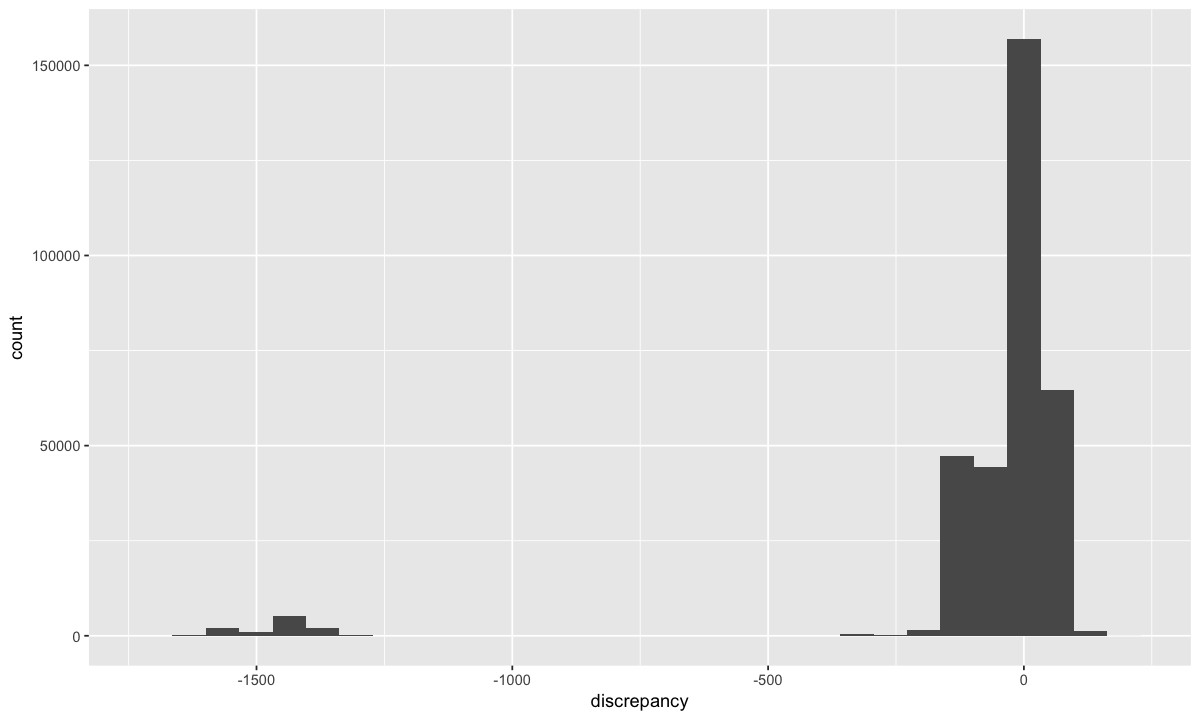

In [22]:
ggplot(discrepancy) + geom_histogram(aes(x=discrepancy))  # shortcut ggplot function

### Exercise
What would cause a `discrepancy` of -1500?

In [126]:
filter(my_flights_total, total_time < -1000) %>% select(dep_time, arr_time) %>% print

# A tibble: 10,621 x 2
   dep_time arr_time
      <int>    <int>
 1     1929        3
 2     1939       29
 3     2058        8
 4     2102      146
 5     2108       25
 6     2120       16
 7     2121        6
 8     2128       26
 9     2134       20
10     2136       25
# ... with 10,611 more rows


### Exercise
Add a new variable to `new_total_time` to `my_flights_total` which contains a "corrected" version of `total_time`. Plot the resulting distribution of `new_total_time`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8713 rows containing non-finite values (stat_bin).”

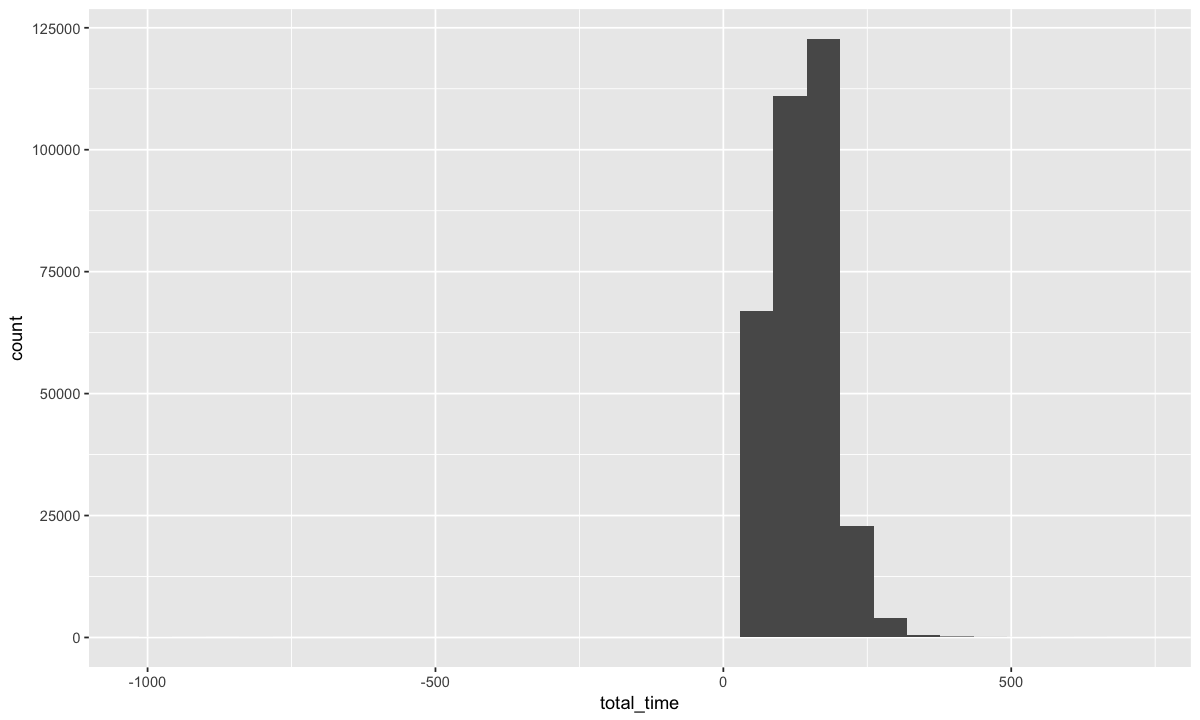

In [142]:
my_flights_total %>% select(total_time) %>% 
    mutate(total_time = total_time + (total_time < -1000) * (24 * 60))  %>% 
    ggplot + geom_histogram(aes(x=total_time))

### Ranking functions

There are a number of handy functions for ranking data:

* `min_rank(v)`: rank the entries of `v` in ascending order, so the smallest entry gets a 1, etc. Ties get the same rank.
* `row_number(v)`: same as `min_rank(v)`, but every entry gets its own rank.
* `dense_rank(v)`: same as `min_rank(v)`, but no gaps created between the ranks.
* `percent_rank()`: ranks expressed in percentiles.
* `cume_dist(v)`: fraction of entries `<=` each entry of `v`.
* `ntile(v)`: group entries of `v` into buckets and report which bucket

In [145]:
c(1, 2, 1, 5, 3, 4, 5) %>% dense_rank()

# (x <- sample(c(11, 12, 12, 14, 14, 14, 17, 21, 26, NA))) # returns a random permutation of the input
#flights %>% mutate(k=min_rank(air_time)) %>% 
#            select(k, year, month, day, tailnum) %>% print

[1] 1 2 1 5 3 4 5

In [31]:
x <- c(1, 1, 2, 3, 4, 4, NA)
dense_rank(x) # don't create gaps in ranks
min_rank(x)

[1]  1  1  2  3  4  4 NA

[1]  1  1  3  4  5  5 NA

In [147]:
c(1, 2, 1, 3, 4, 5)
row_number(x) # just return the position number in sorted order (ties get different ranks here)

[1] 1 2 1 3 4 5

[1]  1  2  3  4  5  6 NA

In [87]:
flights %>% mutate(r = dense_rank(air_time)) %>% 
            select(r, air_time) %>% arrange(r) %>% print

# A tibble: 336,776 x 2
       r air_time
   <int>    <dbl>
 1     1       20
 2     1       20
 3     2       21
 4     2       21
 5     2       21
 6     2       21
 7     2       21
 8     2       21
 9     2       21
10     2       21
# ... with 336,766 more rows


### Exercise

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        How long was the fourth-shortest flight in the air?
        </td>
    <td>
        How long was the fourth-longest flight in the air?
        </td>
    </tr>
    <tr>
<td>
    
1. 21m
2. 34m
3. 36m
4. Depends on how you rank them.
    
</td>        
    <td>
        
1. 690m
2. 686m
3. 683m
4. Depends on how you rank them.

</td>

</tr>
</table>






In [159]:
flights %>% mutate(r = min_rank(-air_time)) %>%
            arrange(r) %>% 
            select(air_time, r) %>% print

# A tibble: 336,776 x 2
   air_time     r
      <dbl> <int>
 1      695     1
 2      691     2
 3      686     3
 4      686     3
 5      683     5
 6      679     6
 7      676     7
 8      676     7
 9      675     9
10      671    10
# ... with 336,766 more rows


## Grouped Summaries
`summarize()` can be used to summarize entire data frames by collapsing them into single number summaries. The syntax is similar to mutate:
```{r}
summarize(<grouped tibble>, <new variable> = <formula for new variable>,
                            <other new variable> = <other formula>)
```
As opposed to `mutate()`, which generates a new column and entry for each row, `summarize()` first groups columns and then applies a summary function. It returns a new tibble with **one row per group**.

The most basic use of summarize is to compute statistics over the whole data set:

In [161]:
summarize(flights, delay = mean(dep_delay, na.rm=TRUE)) %>% print

# A tibble: 1 x 1
  delay
  <dbl>
1  12.6


### Grouping observations
`summarize()` is most useful when combined with `group_by()` to group observations before calculating the summary statistic. The `group_by` function tells R how your data are grouped:

In [164]:
flights %>% group_by(year, month, day) %>% print
# by_month <- group_by(flights, year, month)

# A tibble: 336,776 x 19
# Groups:   year, month, day [365]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753        

In [165]:
group_by(flights, month) %>% summarize(mean_dep_delay=mean(dep_delay, na.rm=T)) %>% print

# A tibble: 12 x 2
   month mean_dep_delay
   <int>          <dbl>
 1     1          10.0 
 2     2          10.8 
 3     3          13.2 
 4     4          13.9 
 5     5          13.0 
 6     6          20.8 
 7     7          21.7 
 8     8          12.6 
 9     9           6.72
10    10           6.24
11    11           5.44
12    12          16.6 


Many summary functions are available:

* Center: `mean(), median()`
* Spread: `sd(), IQR(), mad()`
* Range: `min(), max(), quantile()`
* Position: `first(), last(), nth()`
* Count: `n(), n_distinct()`
* Logical: `any(), all()`

### Examples
Compute the number of flights each month:

In [168]:
group_by(flights, month, tailnum) %>% summarize(n())

      month tailnum n()
1     1     N0EGMQ  41 
2     1     N10156  28 
3     1     N102UW   1 
4     1     N103US   4 
5     1     N104UW   2 
6     1     N10575  30 
7     1     N107US   1 
8     1     N108UW   1 
9     1     N109UW   1 
10    1     N110UW   1 
11    1     N11106   8 
12    1     N11107  11 
13    1     N11109  13 
14    1     N11113   5 
15    1     N11119  20 
16    1     N11121   3 
17    1     N11127   8 
18    1     N11137   8 
19    1     N11140  14 
20    1     N11150  11 
21    1     N11155   3 
22    1     N11164  17 
23    1     N11165   4 
24    1     N11176  14 
25    1     N11181  12 
26    1     N11184  20 
27    1     N11187  21 
28    1     N11189  11 
29    1     N11191  13 
30    1     N11192   8 
⋮     ⋮     ⋮       ⋮  
37959 12    N983AT    3
37960 12    N983DL   12
37961 12    N984DL    4
37962 12    N985AT    2
37963 12    N985DL    5
37964 12    N986AT    3
37965 12    N986DL    6
37966 12    N987AT    1
37967 12    N987DL    4
37968 12    N988

### Exercise

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        Which plane (tail number) flew the most flights in July?
        </td>
    <td>
        How many planes flew at least one flight in January, but none in February?
        </td>
    </tr>
    <tr>
<td>
</tr>
</table>






In [56]:
# Your code here

### Always include counts
It is a good idea to include counts of each group when you do a summary. Some groups may have very low numbers of observations, resulting in high variance for the summary statistics. For example, let's look at particular airplanes which have high delays, perhaps due to maintenance, etc:

In [89]:
not_cancelled = flights %>% 
    filter(!is.na(dep_delay), !is.na(arr_delay))

not_cancelled %>% group_by(tailnum) %>% 
    summarise(delay = mean(arr_delay)) %>% top_n(5)

Selecting by delay


  tailnum delay
1 N587NW  264  
2 N844MH  320  
3 N851NW  219  
4 N911DA  294  
5 N922EV  276  

The top five most delayed planes experience an average delay of 4-5 hours! Clearly this is not realistic. The issue is that there are very few observations for each of these planes:

In [55]:
delays = not_cancelled %>% group_by(tailnum) %>% 
    summarise(delay=mean(arr_delay), obs=n())

top_n(delays, 5, delay)

  tailnum delay obs
1 N587NW  264   1  
2 N844MH  320   1  
3 N851NW  219   1  
4 N911DA  294   1  
5 N922EV  276   1  

Here is another example from baseball:

In [60]:
library(Lahman)
bat <- as_tibble(Batting) %>% print

# A tibble: 102,816 x 22
   playerID yearID stint teamID lgID      G    AB     R     H   X2B   X3B    HR
   <chr>     <int> <int> <fct>  <fct> <int> <int> <int> <int> <int> <int> <int>
 1 abercda…   1871     1 TRO    NA        1     4     0     0     0     0     0
 2 addybo01   1871     1 RC1    NA       25   118    30    32     6     0     0
 3 allisar…   1871     1 CL1    NA       29   137    28    40     4     5     0
 4 allisdo…   1871     1 WS3    NA       27   133    28    44    10     2     2
 5 ansonca…   1871     1 RC1    NA       25   120    29    39    11     3     0
 6 armstbo…   1871     1 FW1    NA       12    49     9    11     2     1     0
 7 barkeal…   1871     1 RC1    NA        1     4     0     1     0     0     0
 8 barnero…   1871     1 BS1    NA       31   157    66    63    10     9     0
 9 barrebi…   1871     1 FW1    NA        1     5     1     1     1     0     0
10 barrofr…   1871     1 BS1    NA       18    86    13    13     2     1     0
# ... with 102,

There is one row per player per year:

In [102]:
slice(bat, 1)
Lahman::playerInfo('abercda01')

  playerID  yearID stint teamID lgID G AB R H X2B ⋯ RBI SB CS BB SO IBB HBP SH
1 abercda01 1871   1     TRO    NA   1 4  0 0 0   ⋯ 0   0  0  0  0  NA  NA  NA
  SF GIDP
1 NA NA  

   playerID  nameFirst nameLast   
21 abercda01 Frank     Abercrombie

### Exercise
A player's *batting average* is defined as their hits (`H`) divided by their at-bats (`AB`). Add up all the hits and at-bats for each player across all the years they played and compute their career batting average. Which player(s) has the highest career batting average?

In [174]:
Batting %>% group_by(playerID) %>% 
    summarize(bavg = sum(H) / sum(AB), nab=sum(AB)) %>% 
    filter(nab>100) %>% 
    arrange(desc(bavg))

     playerID  bavg       nab  
1    cobbty01  0.3663635  11434
2    nicolge01 0.3617021    141
3    barnero01 0.3591137   2392
4    hornsro01 0.3584975   8173
5    jacksjo01 0.3557519   4981
6    meyerle01 0.3555094   1443
7    kingst01  0.3529412    272
8    odoulle01 0.3492647   3264
9    delahed01 0.3459027   7505
10   mcveyca01 0.3458018   2513
11   speaktr01 0.3446788  10195
12   willite01 0.3444070   7706
13   hamilbi01 0.3442884   6268
14   broutda01 0.3421249   6711
15   ruthba01  0.3421053   8398
16   orrda01   0.3420493   3289
17   heilmha01 0.3415950   7787
18   brownpe01 0.3414938   4820
19   keelewi01 0.3412874   8591
20   terrybi01 0.3411637   6428
21   cummija01 0.3409091    132
22   sislege01 0.3401476   8267
23   gehrilo01 0.3400825   8001
24   stenzja01 0.3386243   3024
25   burkeje01 0.3384396   8421
26   gwynnto01 0.3381783   9288
27   lajoina01 0.3380957   9589
28   mooreha01 0.3362256    461
29   stephri01 0.3360692   4508
30   pemberu01 0.3358209    134
⋮    ⋮  

### Other uses of aggregation
The `n_distinct()` function returns the number of distinct entries in a group:

In [90]:
tribble(
    ~a, ~x,
    "a", 1,
    "a", 2,
    "b", 3,
    "b", 3
) %>% group_by(a) %>% 
    summarize(nd = n_distinct(x)) %>% print

# A tibble: 2 x 2
  a        nd
  <chr> <int>
1 a         2
2 b         1


### Exercise

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        How many unique destinations were flown to in July?</td>
    <td>Which of the three departure airports (JFK, LGA or EWR) flew to the most 
        unique destinations in July?
    </td>
    </tr>
    <tr>
<td>
</tr>
</table>

In [78]:
# Your code here

### Exercise

<table class="table-condensed">
    <tr><th>Beginner</th><th>Advanced</th></tr>
    <tr><td>
        Let's say an air carrier is <emph>regional</emph> if its median distance traveled per flight is less than 400 miles. Which carriers are regional?</td>
    <td>
        What is the worst-performing air carrier (in terms of median departure delay) for each month of the year??
        </td>
    </tr>
    <tr>
<td>
</tr>
</table>


In [86]:
# Your code here